## Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import glob
from scipy.spatial.distance import cdist
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding,LSTM
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
import csv
import pandas as pd

Using TensorFlow backend.


In [3]:
def load_data_from_csv(filename):    
    with open(filename, newline='', encoding="utf-8") as f:
        reader = csv.reader(f)
        data = list(reader)
    df = pd.read_csv(filename)
    rates = df['rate'].tolist()
    reviews = df['review'].tolist()
    return reviews,rates

In [4]:
%%time
xall,yall = load_data_from_csv('data.csv')
print("Set size: ", len(xall))

Set size:  50000
Wall time: 2.43 s


In [5]:
def count_number_of_samples_for_each_class(yall):
    numberOfSamples = [yall.count(1), yall.count(2), yall.count(3), yall.count(4), yall.count(7), yall.count(8),yall.count(9),yall.count(10)]
    return numberOfSamples

In [6]:
number_of_samples_for_each_class = count_number_of_samples_for_each_class(yall)

In [7]:
number_of_samples_for_each_class

[10122, 4586, 4961, 5331, 4803, 5859, 4607, 9731]

In [8]:
def assign_weight(number_of_all_samples, number_of_clesses, number_of_samples_for_class):
    return number_of_all_samples / (number_of_clesses * number_of_samples_for_class)

In [9]:
def assign_weight_for_each_class(number_of_all_samples, number_of_samples_for_each_class):
    weights = []
    for i in range (0, len(number_of_samples_for_each_class)):    
        x = assign_weight(number_of_all_samples, len(number_of_samples_for_each_class), number_of_samples_for_each_class[i])
        weights.append(x)
    return weights

In [10]:
weights = assign_weight_for_each_class(len(yall), number_of_samples_for_each_class)

In [11]:
weights

[0.6174669037739577,
 1.3628434365460096,
 1.2598266478532554,
 1.1723879197148752,
 1.3012700395586092,
 1.0667349377026796,
 1.3566312133709573,
 0.64227725824684]

In [12]:
########################################################
from keras.utils import to_categorical

for i in range(0,50000):
    yall[i]=yall[i]-1
    
yall=to_categorical(yall)

index_to_delete = [4,5]
updated_ys = []
for i in range(0, len(yall)):
    updated_y = np.delete(yall[i],index_to_delete)
    updated_ys.append(updated_y)

yall=np.asarray(updated_ys)
#############################

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [14]:
stop_words = set(stopwords.words('english'))
processed_reviews = []
single_review = "string to iniialize <br /> my email id is charilie@waoow.com. You can also reach to me at charlie's"

for review in range(0,50000):
    single_review = xall[review]
    
    #removing html tags:
    single_review = re.sub('<.*?>',' ',single_review)
    #removing special characters (punctuation) '@,!' e.t.c.
    single_review = re.sub('\W',' ',single_review)
    #removing single characters
    single_review = re.sub('\s+[a-zA-Z]\s+',' ', single_review)
    #substituting multiple spaces with single space
    single_review = re.sub('\s+',' ', single_review)
    
    #removing stop words
    word_tokens = word_tokenize(single_review)
    
    filtered_sentence = " ".join([w for w in word_tokens if w not in stop_words])
    #compile all the sentences to make a complete dictionary of processed reviews
    processed_reviews.append(filtered_sentence)
    
print(processed_reviews[0])

I went saw movie last night coaxed friends mine admit reluctant see knew Ashton Kutcher able comedy wrong Kutcher played character Jake Fischer well Kevin Costner played Ben Randall professionalism The sign good movie toy emotions This one exactly The entire theater sold overcome laughter first half movie moved tears second half While exiting theater saw many women tears many full grown men well trying desperately let anyone see crying This movie great suggest go see judge


In [15]:
from sklearn.model_selection import train_test_split
x_train_text, x_test_text, y_train, y_test = train_test_split(processed_reviews,yall,test_size=0.2,random_state=42)
print("Train-set size: ", len(x_train_text))
print("Test-set size:  ", len(x_test_text))

Train-set size:  40000
Test-set size:   10000


In [42]:
data_text = x_train_text + x_test_text
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data_text)
#tokenizer.word_index
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [43]:
np.mean(num_tokens)

105.3403

In [44]:
np.max(num_tokens)

985

In [45]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

255

In [46]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

In [20]:
#from sklearn import preprocessing
#x_train_pad = preprocessing.scale(x_train_pad)
#x_test_pad = preprocessing.scale(x_test_pad)

In [47]:
x_train_pad.shape

(40000, 255)

In [48]:
x_test_pad.shape

(10000, 255)

In [49]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [50]:
model = Sequential()

In [51]:
weights

[0.6174669037739577,
 1.3628434365460096,
 1.2598266478532554,
 1.1723879197148752,
 1.3012700395586092,
 1.0667349377026796,
 1.3566312133709573,
 0.64227725824684]

In [52]:
embedding_size = 64

In [53]:
optimizer = Adam(lr=0.01)
model = tf.keras.Sequential([
tf.keras.layers.Embedding(num_words, embedding_size),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_size)),
tf.keras.layers.Dense(embedding_size, activation='relu'),
tf.keras.layers.Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 394,824
Trainable params: 394,824
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 394,824
Trainable params: 394,824
Non-trainable params: 0
_________________________________________________________________


In [56]:
x_train_pad

array([[   0,    0,    0, ...,    1,    3, 4947],
       [   0,    0,    0, ..., 1259,  672,    3],
       [   0,    0,    0, ...,   98,    3,  521],
       ...,
       [   0,    0,    0, ...,   37,  511, 2829],
       [   0,    0,    0, ...,  471,  363,  177],
       [   0,    0,    0, ...,  600,   15, 1649]])

In [57]:
class_weight = {0: weights[0],
                1: weights[1],
                2: weights[2],
                3: weights[3],
                4: weights[4],
                5: weights[5],
                6: weights[6],
                7: weights[7]}

In [ ]:
%%time
y_train=np.array(y_train)
history=model.fit(x_train_pad, y_train,
          class_weight=class_weight, validation_split=0.05, epochs=8, batch_size=8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 38000 samples, validate on 2000 samples
Epoch 1/8
38000/38000 [==============================] - 1089s 29ms/sample - loss: 1.6670 - acc: 0.3437 - val_loss: 1.5860 - val_acc: 0.4270
Epoch 2/8
38000/38000 [==============================] - 1101s 29ms/sample - loss: 1.4252 - acc: 0.4540 - val_loss: 1.5336 - val_acc: 0.4185
Epoch 3/8
38000/38000 [==============================] - 1245s 33ms/sample - loss: 1.2857 - acc: 0.5092 - val_loss: 1.5804 - val_acc: 0.4070
Epoch 4/8
38000/38000 [==============================] - 1073s 28ms/sample - loss: 1.1602 - acc: 0.5574 - val_loss: 1.6809 - val_acc: 0.4070
Epoch 5/8
38000/38000 [==============================] - 1248s 33ms/sample - loss: 1.0288 - acc: 0.6083 - val_loss: 1.8558 - val_acc: 0.3820
Epoch 6/8
38000/38000 [==============================] - 1146s 30ms/sample - loss: 0.9077 - acc: 0.6558 - val_loss: 1.9536 - val_acc: 0.3995
Epoch 7/8
32328/38000 [========================>.....] 

In [33]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

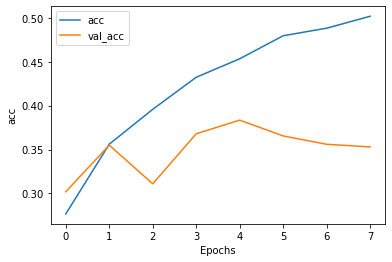

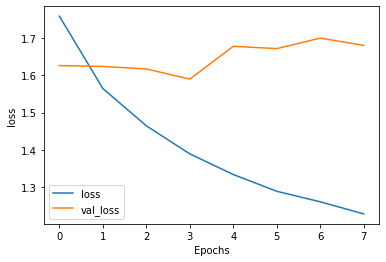

In [34]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [35]:
%%time
y_test=np.array(y_test)
result = model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 1.6238 - acc: 0.3697
Wall time: 4.7 s


In [36]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 36.97%


In [37]:
%%time
y_pred = model.predict(x=x_test_pad[0:2000])
#y_pred = y_pred.T[0]

Wall time: 1.5 s


In [39]:
##Saving and loading model
model.save("ModelEqualDistroNoDeleteBidirectional")
#model = keras.models.load_model("path_to_my_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ModelEqualDistroNoDeleteBidirectional\assets


In [40]:
#exampleReview="I had high expectations for this movie. When I saw Shrek 2, I was pleasantly surprised. Few sequels are as good as the original, but Shrek 2 was. Shrek the third did not continue this trend. While there were sill plenty of funny moments, it was nowhere near as amusing or original as the first two. They could have done so much more with this movie if they had tried. At the end, I felt sort of cheated. However, Shek the third isnt a bad movie in itself, only when compared to the others. I would still recommend going to see it. Unlike most, I liked Arties character, even if he did talk too much (Im not even a Justin Timberlake fan)."
#10
#exampleReview="The Godfather: Part II is a very suspenseful drama with a very exciting story, with great acting and great special effects. I would definitely recommend you watch this movie...but first watch the original classic from 1972 The Godfather . The movie may not be as good as the first movie but is still an amazing sequel."
#7
exampleReview="If you like Karate, you will love this. I like the fight scenes, and the bad guy in the film is always a bad guy in Karate movies. ( ie Enter The Dragon) It is a bit sloppy in spots, but considering the budget you can not hit this film too hard. It is a good film to see if your mad or angry at someone."
#1
#exampleReview="If I thought the overlong, frightfully dull Avatar contained and rehashed every Hollywood cliché ever used, albeit in blue, Prince of Persia: Sands of Time runs the gamut of every mindless Hollywood action-feature effect, computerized or not, and even as an admittedly escapism event, it falls short of any intended mark. It is obvious that there is little new under the Hollywood sun. Frankly, 1942's Arabian Nights did this plot line much better and Shemp Howard, of Three Stooges fame, surpassed Alfred Molina's deadly dull and ineffective attempt at humor. Jake Gyllenhaal, in spite of much daring-do stunts and macho posturing, is still not the virile stud hero that his handlers are trying to turn him into, and Arterton's clichéd bitchy dialog becomes tedious after 10 minutes. It's a shallow waste of time from beginning to end and how Ben Kingsley could keep a straight face throughout this loud, noisy romp is a testament to his enormous experience in front of a camera."
#6
#exampleReview="Reading some of the harsh reviews I thought I would comment. The big disappointment for me in the movie was the lack of gore , fox did get it wrong to make it a pg13 even though they tried to substitute it with monster gore. All that being said this movie is a visual master-peace, the effects are top notch with very good fight scenes and creature effects with the best looking Alien Queen to hit the screens, The story is pretty cool and it gives more insight of the Predators, It takes a while for the introduction of the creatures but once the ball is rolling its none stop action. Not the horror feast we all wanted but fun."
#3
#exampleReview="In this final chapter of the ROCKY series, the Italian Stallion, now broke and brain damaged from his last fight, faces a promoter who wants him to do another bout, an amateur boxer whom he agrees to train, and his own son who starts to feel neglected. This time around, even Stallone gives a weak performance, and Tommy Morrison fails to make an impression as Rocky's Robot Tommy Gunn. Sly's real-life son Sage, who plays Rocky Jr,, and Burgess Meredith's brief appearance as Mickey are the only characters with any interest. The bottom spot of the movie is the climaxing streetfight, which barely makes the film worth a watch."

In [41]:
%%time
y_pred = model.predict(x=x_test_pad)

Wall time: 3.31 s


In [42]:
y_res=[]
y_test_res=[]
##pred
for i in range(0,len(y_pred)):
    rate=np.argmax(y_pred[i])
    y_res.append(rate)

for i in range(0,len(y_test)):
    rate=np.argmax(y_test[i])
    y_test_res.append(rate)

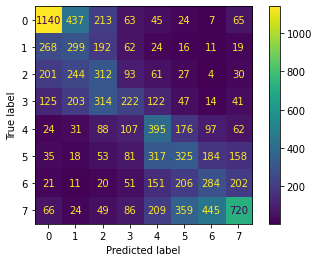

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test_res,y_res)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i] and y_hat[i]>5.0:
           TP += 1
        if y_hat[i]>5.0 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i] and y_hat[i]<=5.0:
           TN += 1
        if y_hat[i]<=5.0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return(TP, FP, TN, FN)

In [ ]:
TP, FP, TN, FN = perf_measure(y_test_res, y_res);

In [ ]:
import math  

In [ ]:
def calculate_metrics(TP, FP, TN, FN):
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    NPV = TN/(TN+FN)
    #miss_rate = 1-sensitivity
    #fall_out = 1-specificity
    #FDR = 1-precision
    #false_omission_rate = 1-NPV
    #PT = math.sqrt(sensitivity*(-specificity+1))+specificity-1/(sensitivity+specificity-1)
    #threat_score = TP/(TP+FN+FP)
    return sensitivity, specificity, precision, NPV, PT, threat_score

In [ ]:
#NPV - negative predictive value
#FDR - false discovery rate
#FOR - false omission rate
#PT - prevalence threshold
sensitivity, specificity, precision, NPV = calculate_metrics(TP, FP, TN, FN)